In [ ]:
# 必要なライブラリをインストール
!pip install japanize_matplotlib
!pip install pmdarima

In [2]:
# ライブラリを起動
from dateutil.relativedelta import relativedelta
import japanize_matplotlib
import math as math
import numpy as np
import pandas as pd
import scipy as sp
import random
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 15, 6
# Colabでファイルを読み込むために、Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# (2) 2変量モデルの構造ショックの識別

## (2-1) 物価水準と金利の2変量VARモデル

*   変数：物価水準と金利の2変数
*   物価水準は、消費者物価指数（除く生鮮食品・エネルギー、消費税率引き上げの影響は調整）
*   金利は、公定歩合とシャドーレートの接続系列（かつて日本銀行の主な金融調節手段は公定歩合であったが、1990年代以降、無担保コールレート翌日物金利が金融市場調節の主たる操作目標となったこと、また無担保コールレート翌日物金利がゼロ下限に達した期間ではシャドーレートが金利と代理変数とみなせることによる。シャドーレートは、もし金利のゼロ下限が存在しなかったときの仮想的な金利水準であり、複数の推計値が存在する。ここでは、Krippner(2015)の方法による推計値を用いて、1994年までは公定歩合、1995年からはシャドーレートとした）
*   期間は1972年第1四半期から2023年第4四半期

(730.0, 19631.0)

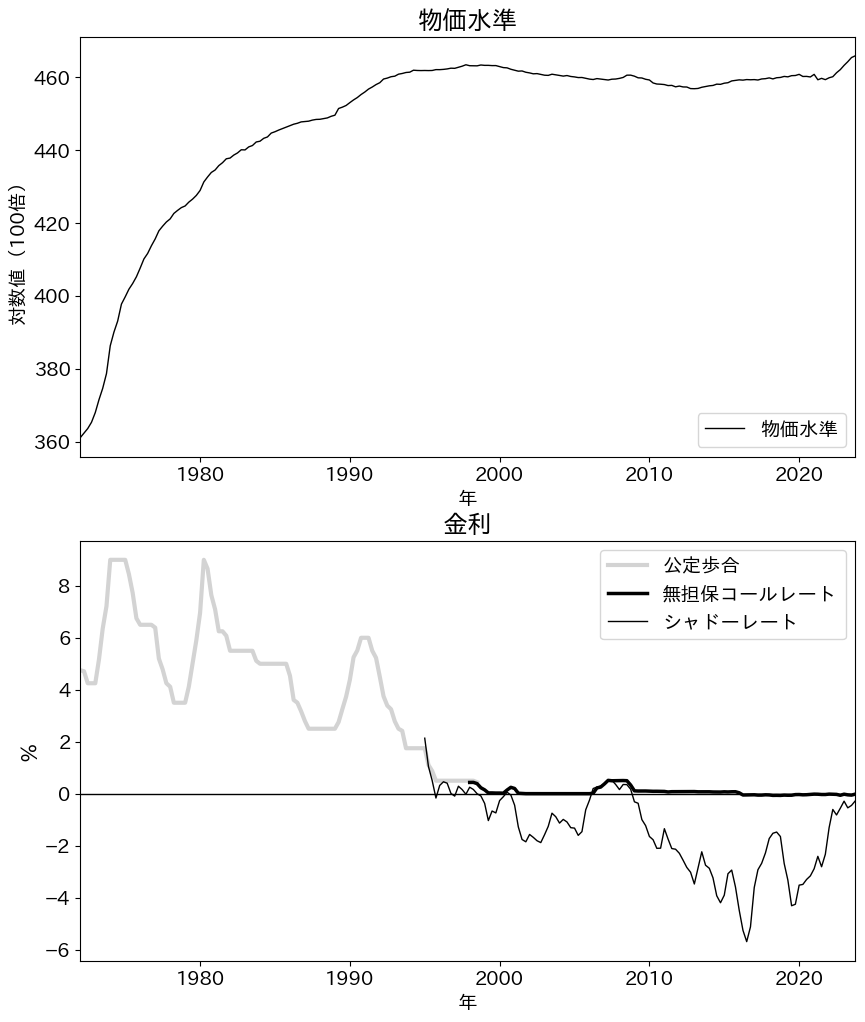

In [3]:
# データの読み込みと図示
dinput = pd.read_excel('/content/drive/My Drive/Data/data_VAR2.xlsx',
                       sheet_name='data_q', header=[0])
data = np.zeros([len(dinput), 2])
for i in range(1, len(dinput)):
    data[:, 0] = np.log(dinput.cpi)
    temp = pm.arima.decompose(data[:, 0], 'additive', m=4)
    data[:, 0] = (np.log(dinput.cpi) - temp.seasonal) *100
    data[:, 1] = dinput.RSR
data = data[0:]
dlen = len(data)
dti = pd.date_range('1972-01-01', periods=dlen, freq='QS')
graphdata = np.zeros([len(dinput), 3])
for i in range(1, len(dinput)):
    graphdata[:, 0] = dinput.Rkotei
    graphdata[:, 1] = dinput.Rcall
    graphdata[:, 2] = dinput.SR
graphdata = graphdata[0:]

# グラフの描画
fig = plt.figure(figsize=(10, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title('物価水準', fontsize=18)
ax1.plot(dti, data[:, 0], color='black', linewidth=1, label='物価水準')
ax1.tick_params(labelsize=14)
ax1.set_xlabel('年', fontsize=14, loc='center')
ax1.set_ylabel('対数値（100倍）', fontsize=14)
ax1.legend(loc='lower right', fontsize=14)
ax1.set_xlim(dti[0], dti[-1])
ax2.set_title('金利', fontsize=18)
ax2.plot(dti, graphdata[:, 0], color='lightgrey', linewidth=3, label='公定歩合')
ax2.plot(dti, graphdata[:, 1], color='black', linewidth=2.5,
         label='無担保コールレート')
ax2.plot(dti, graphdata[:, 2], color='black', linewidth=1,
         label='シャドーレート')
ax2.hlines([0], ['1972-01-01'], ['2023-10-01'], color='black', linewidth=1)
ax2.tick_params(labelsize=14)
ax2.set_xlabel('年', fontsize=14, loc='center')
ax2.set_ylabel('％', fontsize=14)
ax2.legend(loc='upper right', fontsize=14)
ax2.set_xlim(dti[0], dti[-1])

## (2-2) VAR(1)モデルの場合

ショックのサイズは誤差項の1標準偏差（物価水準が$0.583$上昇、金利が$0.456$上昇）

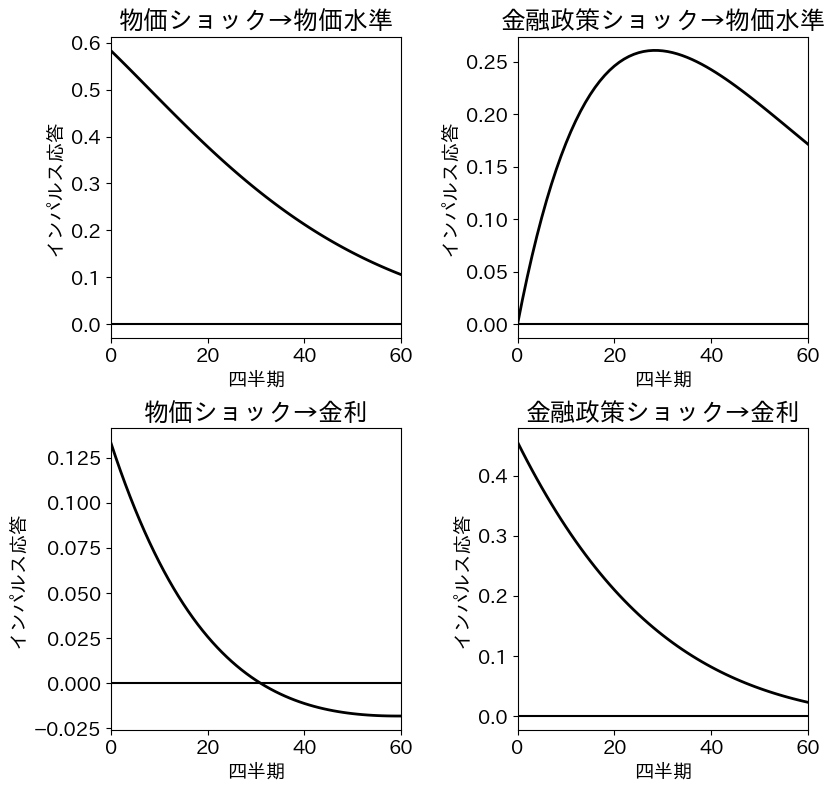

In [4]:
# VARモデルの推定
model = VAR(data)
PERIOD = 60
results = model.fit(1)
irf = results.irf(PERIOD)

# グラフの描画
vnames = ['物価水準', '金利']
snames = ['物価ショック', '金融政策ショック']
fig, ax = plt.subplots(2, 2, figsize=[9, 9])
for i in range(2):
    for j in range(2):
        ax[i,j].plot(irf.orth_irfs[:,i,j], linewidth=2, color='black')
        ax[i,j].hlines([0], 0, PERIOD, color='black', linestyle='solid')
        ax[i,j].set_xlim(0, PERIOD)
        ax[i,j].set_xlabel('四半期', fontsize=14)
        ax[i,j].tick_params(labelsize=14)
        ax[i,j].set_ylabel('インパルス応答', fontsize=14)
        ax[i,j].set_title('%s→%s' %(snames[j],vnames[i]), fontsize=18)
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

In [5]:
# VARモデルの誤差項の分散共分散行列
print('誤差項の分散共分散行列\n', results.sigma_u)

# VARモデルのショックのサイズの計算
L = np.linalg.cholesky(results.sigma_u)
print('ショックの1標準偏差 (c11とc22) \n', np.diag(L))
print('c21 \n', L[1, 0])

誤差項の分散共分散行列
 [[0.34036957 0.07794749]
 [0.07794749 0.22547841]]
ショックの1標準偏差 (c11とc22) 
 [0.58341201 0.45566192]
c21 
 0.13360624804566948


## (2-3) VAR(p)モデルの場合

ラグ次数はAICに基づき、5が選択される

ショックのサイズは誤差項の1標準偏差（物価水準が$0.476$上昇、金利が$0.395$上昇）

推計結果は以下のとおり。
*   金融政策ショック → 物価水準：金融引き締めショックは物価水準を押し下げるが、ショック直後の期間については物価水準が上昇する物価パズルが観察される
*   物価ショック → 金利：政策ルールに基づき、物価上昇ショックに対しては、利上げで対応する

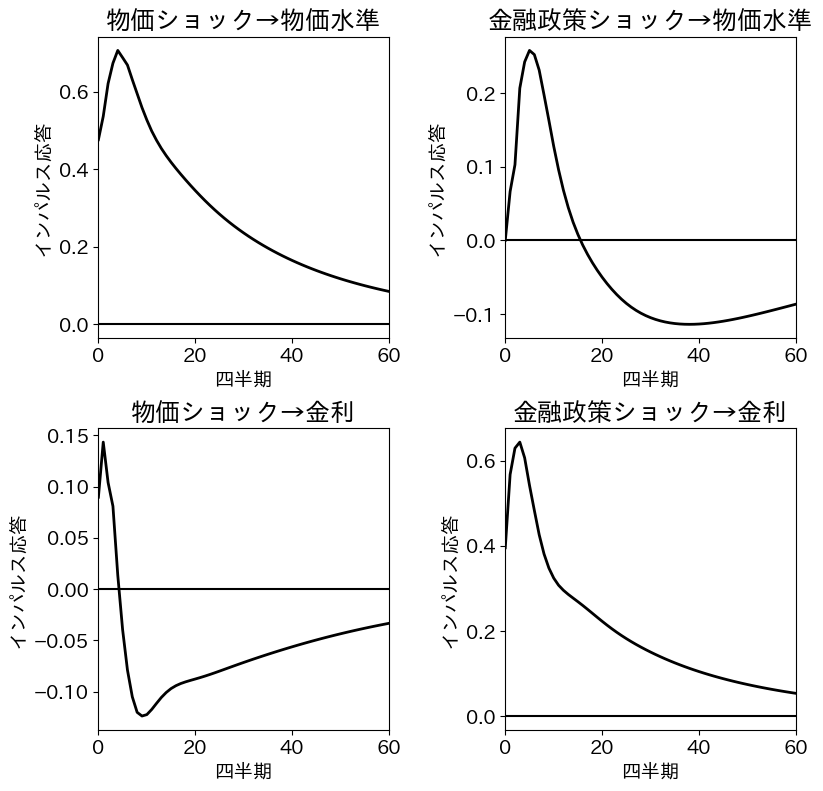

In [6]:
# VARモデルの推定
model = VAR(data)
PERIOD = 60
results = model.fit(maxlags=20, ic="aic")
lag_order = results.k_ar
irf = results.irf(PERIOD)

# グラフの描画
vnames = ['物価水準', '金利']
snames = ['物価ショック', '金融政策ショック']
fig, ax = plt.subplots(2, 2, figsize=[9, 9])
for i in range(2):
    for j in range(2):
        ax[i,j].plot(irf.orth_irfs[:,i,j], linewidth=2, color='black')
        ax[i,j].hlines([0], 0, PERIOD, color='black', linestyle='solid')
        ax[i,j].set_xlim(0, PERIOD)
        ax[i,j].set_xlabel('四半期', fontsize=14)
        ax[i,j].tick_params(labelsize=14)
        ax[i,j].set_ylabel('インパルス応答', fontsize=14)
        ax[i,j].set_title('%s→%s' %(snames[j],vnames[i]), fontsize=18)
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

In [7]:
# ラグ次数
print('ラグ次数\n', lag_order)

# VARモデルの誤差項の分散共分散行列
print('誤差項の分散共分散行列\n', results.sigma_u)

# VARモデルのショックのサイズの計算
L = np.linalg.cholesky(results.sigma_u)
print('ショックの1標準偏差 (c11とc22) \n', np.diag(L))
print('c21 \n', L[1, 0])

ラグ次数
 5
誤差項の分散共分散行列
 [[0.22641821 0.04267438]
 [0.04267438 0.16421436]]
ショックの1標準偏差 (c11とc22) 
 [0.47583423 0.39518511]
c21 
 0.08968329606177876
